# Movies similarity graph
Many open datasets provide information about movies, in particular IMDB (https://www.imdb.com), TMDB (https://www.themoviedb.org), and MovieLens (https://grouplens.org/datasets/movielens/).

A cleaned dataset joining information from these different sources on a subset of movies is available on Kaggle: https://www.kaggle.com/rounakbanik/the-movies-dataset

In this project, we will create a network of similarity between movies based on this data

# Preprocessing the data
Start by downloading the data from Kaggle: (900 MB) https://www.kaggle.com/rounakbanik/the-movies-dataset, and put the files in the same folder as this file.

Then, I provide some code to join the most important datasets with common IDs, and filter them to keep only a subset of the most famous movies

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [11]:
#Importing data
location="/Users/remycazabet/ownCloud/cours/ComplexNetworks/data-network/dataset-movies-dblp/"
ratings = pd.read_csv(location+"ratings.csv")
links = pd.read_csv(location+"links.csv")
keywords = pd.read_csv(location+"keywords.csv")
movies = pd.read_csv(location+"movies_metadata.csv")
movies["id"]=pd.to_numeric(movies["id"],errors="coerce")


In [12]:
# Select the top N movies
N=30
top=movies.sort_values("vote_count",ascending=False)[:N]

In [13]:
#Add keywords to other movies info
links["imdb_id"]=["tt"+str(s).zfill(7) for s in list(links["imdbId"])]
top=top.merge(links,how="left",on="imdb_id")
top=top.merge(keywords,how="left",on="id")

In [14]:
#Keep only the votes concerning the selected movies
top_ratings=ratings[ratings['movieId'].isin(list(top["movieId"]))]

# Movies relations
Based on this dataset, there are many possible ways to create a network. You can for instance consider add an edge between movies of the same genres (but you will have a lot of edges), or that have keywords in common. You could also use additional information such as spoken languages, production countries, runtime, etc.
Using some basic natural language processing, you could also use text information from the title, overview and tagline.

Bust most of this information is quite limited, since it cannot take into account the full complexity of what makes a movie similar to another or not, such as atmosphere, plot, etc.

The best way to capture this is therefore to leverage user votes. The principle is that the more people tend to give similar votes (or high votes) to the same movies, the more these movies can be considered similar. This is the principle of methods used by Netflix, Amazon, etc. to recommend items to customers (See Collaborative Filtering).

In [15]:
#Transforming the vote list into a matrix MovieXuser
pivoted=top_ratings.pivot(index='movieId', columns='userId', values='rating')
pivoted=pivoted.replace(np.NaN,0)
as_matrix=pivoted.to_numpy()

#collecting the movies info in the same order as the matrix.
movieID=list(pivoted.index)
moviesAsDf=pd.DataFrame({"movieId":movieID})
moviesAsDf=moviesAsDf.merge(top,on="movieId")
movieNames=list(moviesAsDf["original_title"])

## Example: cosine similarity
A simple way to compute the similarity between movies is to compute the cosine similarity between the rows corresponding to each movie.

In [16]:
similarities = cosine_similarity(as_matrix)

In [17]:
#filtering low values
similarities[similarities <= 0.5] = 0 

In [18]:
g = nx.from_numpy_matrix(similarities)
g = nx.relabel_nodes(g,{i:movieNames[i] for i in range(len(movieID))})

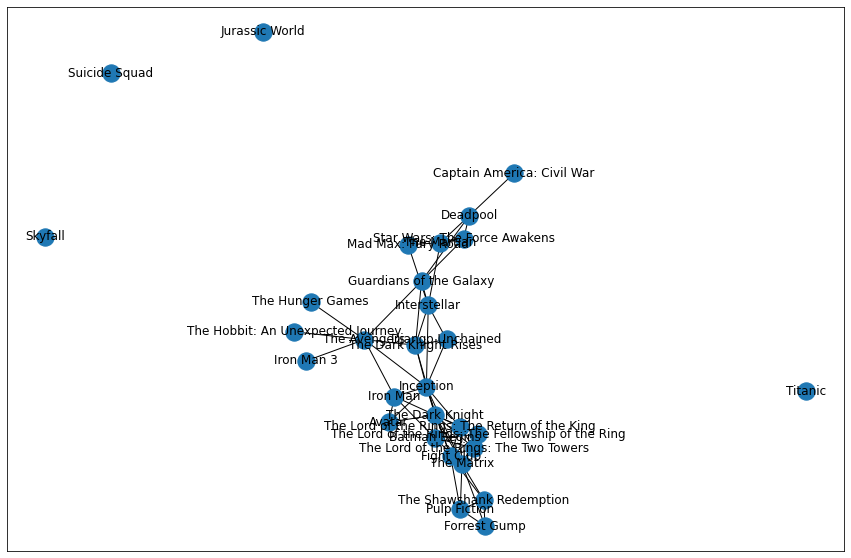

In [19]:
plt.figure(1,figsize=(15,10)) 
nx.draw_networkx(g)

In [20]:
#for i,movie1 in enumerate(as_matrix):
#    ratings1=list(movie1)
#    for j,movie2 in enumerate(as_matrix):
#        ratings2=list(movie2)
#        print(i,j,np.mean([abs(ratings1[k]-ratings2[k]) for k in range(len(ratings1)) if ratings1[k]>0 and ratings2[k]>0]))
